## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №19

Реализовать алгоритмы Стэкинг, Бэгин и Бустинг.  
При реализации алгоритмов не использовать готовые решения.  
За сровнение взять CatBoostClassifier как базовая метрика качества. Сравнить результат с реализацией своих ансамблей.  
Для однозначности и интерпретируемости результатов использовать приложенный набор данных. 

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer

RANDOM_STATE = 42

# Функция генерации файла результатов
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

Загрузить данные

In [255]:
df = pd.read_csv('winequality-white.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [256]:
print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

#TODO: проверить наличие противоречивых записей (с различным значением целевого признака при совпадении всех прочих )

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Данные после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 937
Данные после удаления дубликатов: (3961, 12)


Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

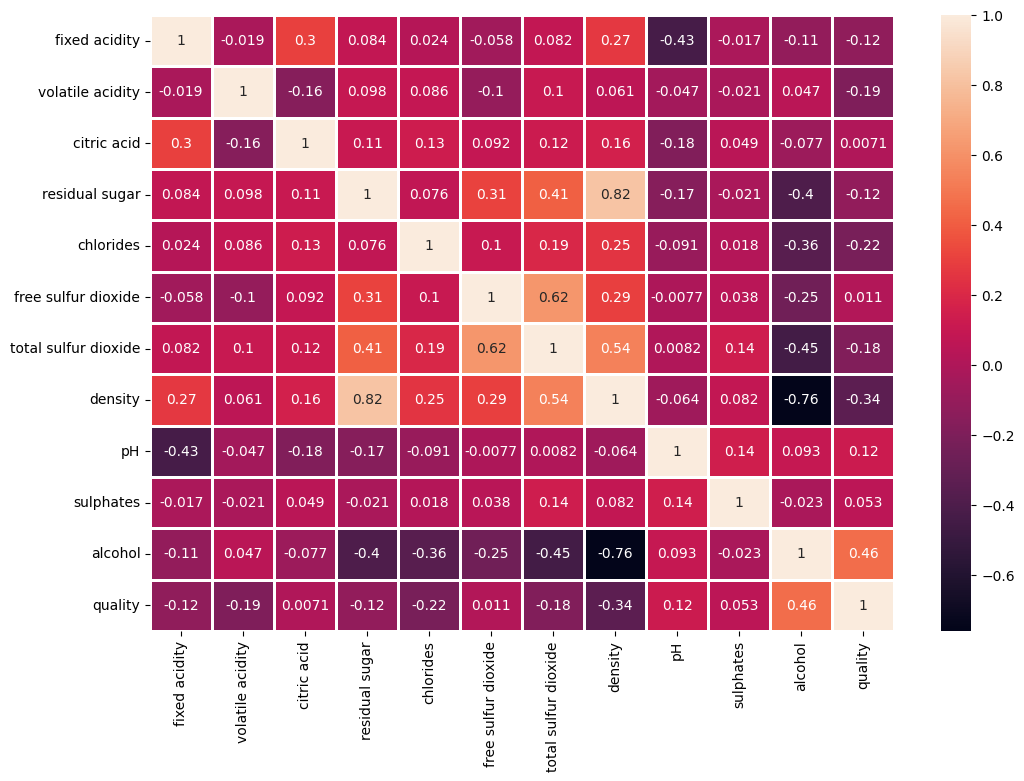

In [257]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается существенная корреляция признака _alcohol_ c большей частью остальных признаков и главное - с целевым признаком _quality_ !!!
Считаю целесообразным удалить данный признак из набора данных
- Признак Общего диоксида серы (total sulfur dioxide) включает в себя свободную (free sulfur dioxide) и связанную форму, Но именно свободная форма оказывает влияние на вкус и запах вина !!!
Считаю целесообразным удалить признак Общего диоксида серы из-за его существенной корреляции с признаком свободной формы.

In [258]:
# Удалить признаки total_sulfur_dioxede и alcohol
df.drop(['total sulfur dioxide','alcohol'], axis=1, inplace=True)

Визуализировать аномальные значения признаков

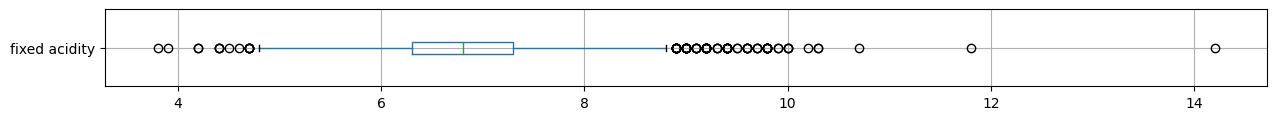

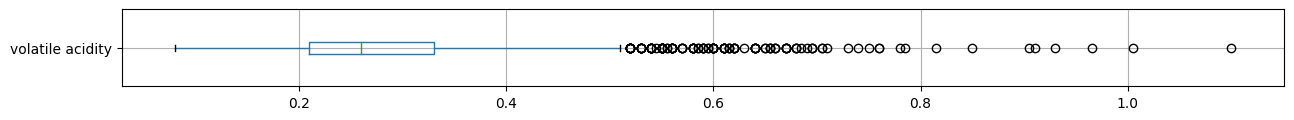

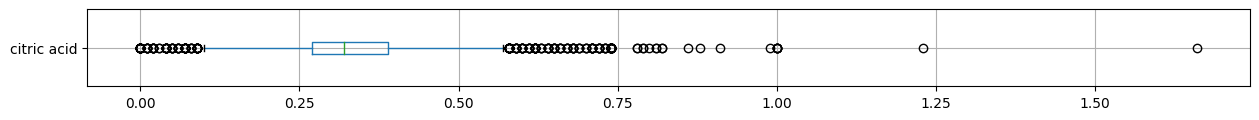

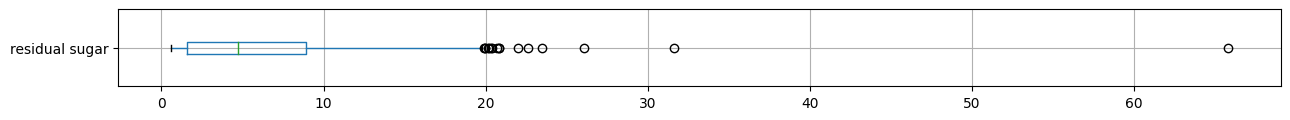

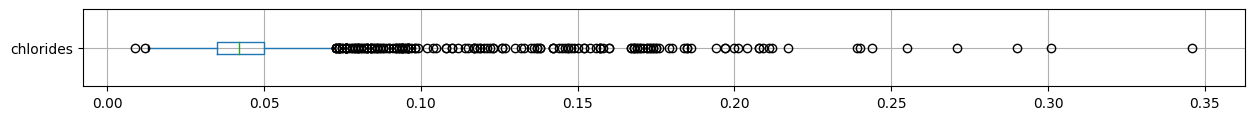

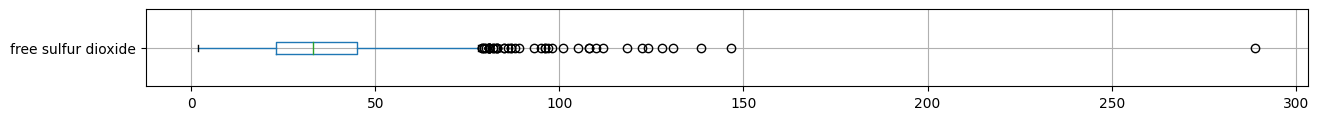

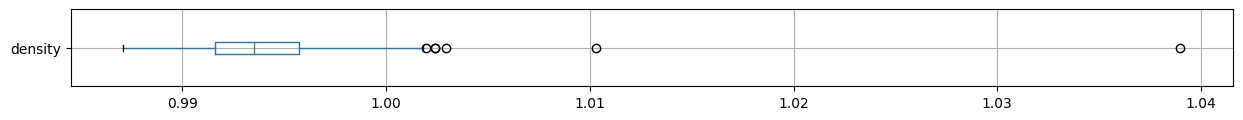

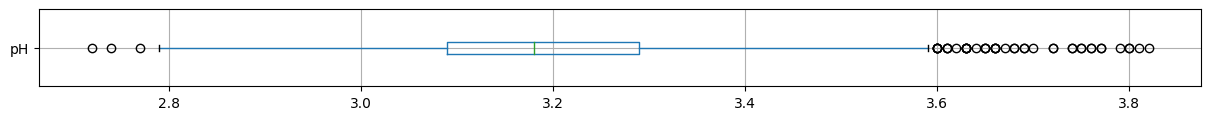

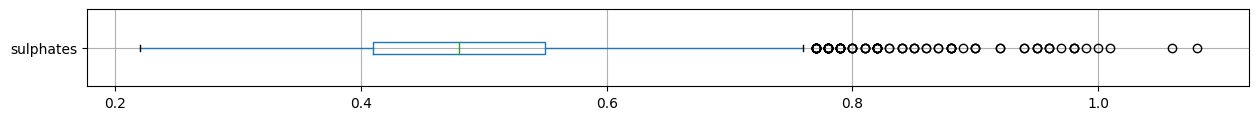

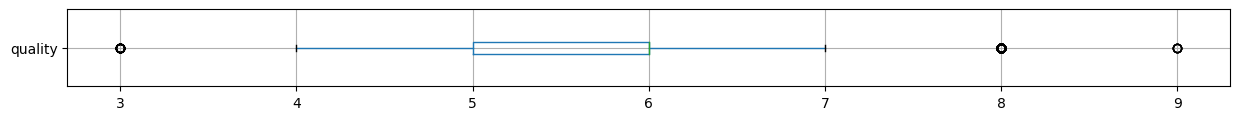

In [259]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [260]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3961.0,6.839346,0.866860,3.80000,6.30000,6.8000,7.30000,14.20000
volatile acidity,3961.0,0.280538,0.103437,0.08000,0.21000,0.2600,0.33000,1.10000
citric acid,3961.0,0.334332,0.122446,0.00000,0.27000,0.3200,0.39000,1.66000
residual sugar,3961.0,5.914819,4.861646,0.60000,1.60000,4.7000,8.90000,65.80000
chlorides,3961.0,0.045905,0.023103,0.00900,0.03500,0.0420,0.05000,0.34600
free sulfur dioxide,3961.0,34.889169,17.210021,2.00000,23.00000,33.0000,45.00000,289.00000
density,3961.0,0.993790,0.002905,0.98711,0.99162,0.9935,0.99571,1.03898
pH,3961.0,3.195458,0.151546,2.72000,3.09000,3.1800,3.29000,3.82000
sulphates,3961.0,0.490351,0.113523,0.22000,0.41000,0.4800,0.55000,1.08000
quality,3961.0,5.854835,0.890683,3.00000,5.00000,6.0000,6.00000,9.00000


In [261]:
# Удалить записи с максимальными значениями выбросов
df.drop(df[df['fixed acidity'] > 12].index, inplace=True)
df.drop(df[df['volatile acidity'] > 1.1].index, inplace=True)
df.drop(df[df['citric acid'] > 1.25].index, inplace=True)
df.drop(df[df['residual sugar'] > 40].index, inplace=True)
df.drop(df[df['chlorides'] > 0.32].index, inplace=True)
df.drop(df[df['free sulfur dioxide'] > 150].index, inplace=True)
df.drop(df[df['density'] > 1.02].index, inplace=True)

Оценить распределение значений классов целевой метрики "quality"

In [262]:
df.quality.value_counts()

6    1785
5    1174
7     689
4     153
8     131
3      19
9       5
Name: quality, dtype: int64

Набор целевых классов не сбалансированный.
- Выполним секвестр классов согласно бальной системы AIS (Итальянская ассоциация сомелье): 
    - ниже 6 балов - неудовлетворительно (0 балов)
    - 6 баллов - удовлетворительно (1 бал)
    - больше 6 балов - хорошо и отлично (2 бала)

Для оценки моделей будем применять метрики ROC_AUC, F-measure


In [263]:
df.loc[df.quality < 6 , 'quality'] = 0 
df.loc[df.quality == 6, 'quality'] = 1 
df.loc[df.quality > 6 , 'quality'] = 2 

df.quality.value_counts()

1    1785
0    1346
2     825
Name: quality, dtype: int64

Скалирование данных. Подготовка данных для обучения.

array([[<AxesSubplot: title={'center': 'fixed acidity'}>,
        <AxesSubplot: title={'center': 'volatile acidity'}>,
        <AxesSubplot: title={'center': 'citric acid'}>],
       [<AxesSubplot: title={'center': 'residual sugar'}>,
        <AxesSubplot: title={'center': 'chlorides'}>,
        <AxesSubplot: title={'center': 'free sulfur dioxide'}>],
       [<AxesSubplot: title={'center': 'density'}>,
        <AxesSubplot: title={'center': 'pH'}>,
        <AxesSubplot: title={'center': 'sulphates'}>],
       [<AxesSubplot: title={'center': 'quality'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

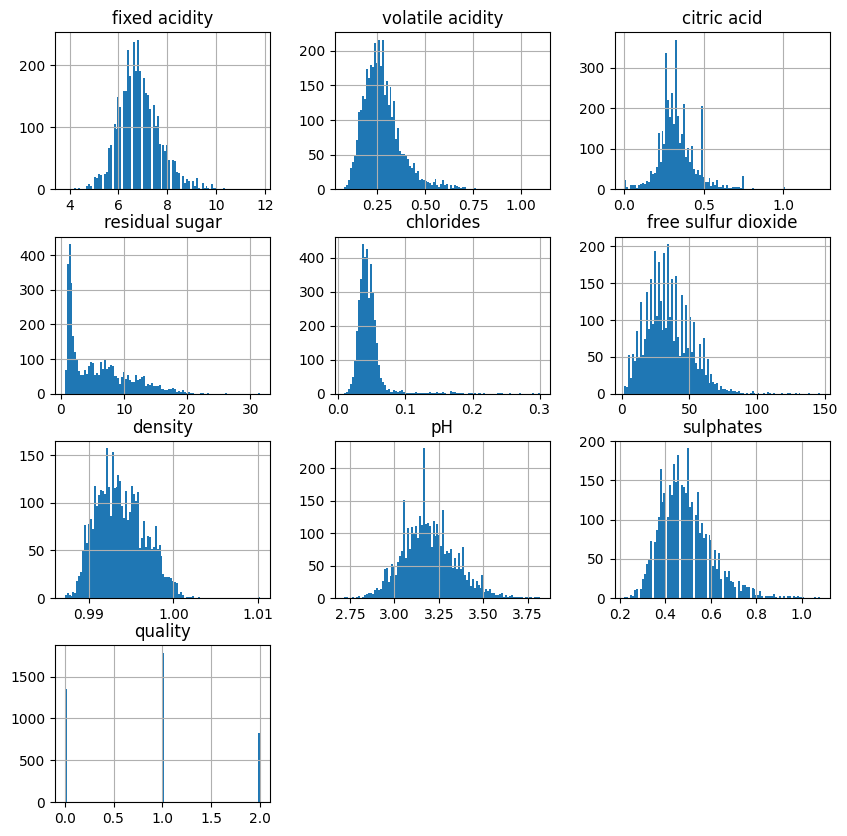

In [264]:
df.hist(bins=100, figsize=(10,10))

In [265]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

y = df['quality'].to_numpy()
X = df.drop('quality', axis=1).to_numpy()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)



# Вычисление и отображение метрик алгоритмов классификации

# Преобразователь значений целевых классов в разряженную матрицу
# для вычисления усредненного значения метрики AUC
lbnr = LabelBinarizer()
lbnr.fit(y_train)

# Словарь усредненых взвешенных значений метрик AUC, Precision, Recall, F-measure
# по всем алгоритмам используемым в задаче
summary_metrics = {}

# Функция печатает развернутые значения метрик для всех целевых классов
def print_full_metrics(y_src, y_pred, lb=None):
    if lb==None:
        print('AUC weighted: {:.3f}'.format(metrics.roc_auc_score(y_src, y_pred, average='weighted')))
    else:
        lbnr.fit(y_src)
        print('AUC weighted: {:.3f}'
            .format(metrics.roc_auc_score(lbnr.transform(y_src), lbnr.transform(y_pred), multi_class='ovr' ,average='weighted')))
    print(metrics.classification_report(y_src,y_pred, zero_division=0))

# Функция возвращает словарь со средними взвешенными значениями метрик AUC, Precision, Recall, F-measure
def get_avg_metrics(y_src, y_pred, lb=None):
    a = 0
    if lb==None:
        a = metrics.roc_auc_score(y_src, y_pred, average='weighted')
    else:
        lb.fit(y_src)
        a = metrics.roc_auc_score(lb.transform(y_src), lb.transform(y_pred), multi_class='ovr' ,average='weighted')

    m = metrics.classification_report(y_src,y_pred, zero_division=0, output_dict=True)['weighted avg']
    return {'auc':a, 'precision':m['precision'], 'recall':m['recall'], 'f1-score':m['f1-score'] }

### CatBoostClassifier

In [266]:
from catboost import CatBoostClassifier
cgb = CatBoostClassifier(verbose=False)

cgb.fit(X_train, y_train)
print_full_metrics(y_train, cgb.predict(X_train), lbnr)

AUC weighted: 0.977
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1021
           1       0.96      0.98      0.97      1337
           2       0.99      0.95      0.97       609

    accuracy                           0.97      2967
   macro avg       0.98      0.97      0.97      2967
weighted avg       0.97      0.97      0.97      2967



In [267]:
y_pred = cgb.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
summary_metrics['CatBoost'] = get_avg_metrics(y_test, y_pred, lbnr)

AUC weighted: 0.658
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       325
           1       0.55      0.66      0.60       448
           2       0.61      0.41      0.49       216

    accuracy                           0.59       989
   macro avg       0.60      0.56      0.57       989
weighted avg       0.59      0.59      0.58       989



## Реализация ансамблевых алгоритмов

### 1. Оценка работы базовых алгоритмов

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

1.1 SVC

In [268]:
c = [0.01, 0.1, 1, 10]
gamma = [0.1,0.5,1,10, 'auto', 'scale']
svc_params= [
    {'C': c,'kernel': ['linear']},
    {'C': c,'kernel': ['rbf'],'gamma': gamma}]

grid = GridSearchCV(SVC(), n_jobs=-1, verbose=5, param_grid = svc_params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
print('Лучшие параметры: ',grid.best_params_)
summary_metrics['SVC'] = get_avg_metrics(y_test, y_pred, lbnr)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
AUC weighted: 0.655
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       325
           1       0.55      0.73      0.63       448
           2       0.67      0.27      0.38       216

    accuracy                           0.59       989
   macro avg       0.63      0.54      0.55       989
weighted avg       0.61      0.59      0.58       989

Лучшие параметры:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


1.2 DecisionTreeClassifier

In [269]:
dtc_params={
    'max_depth': [2,3,4,5,6,7,8, None],
    'max_features': [None, 'sqrt', 'auto', 'log2'],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3]}

grid = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), n_jobs=-1, verbose=5, param_grid = dtc_params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
print('Лучшие параметры: ',grid.best_params_)
summary_metrics['DecisionTree'] = get_avg_metrics(y_test, y_pred, lbnr)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
AUC weighted: 0.626
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       325
           1       0.52      0.59      0.55       448
           2       0.51      0.38      0.44       216

    accuracy                           0.54       989
   macro avg       0.54      0.52      0.53       989
weighted avg       0.54      0.54      0.54       989

Лучшие параметры:  {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


1.3 KNeighborsClassifier

In [270]:
knc_params = {
    'n_neighbors': range(10,15, 1),
    'leaf_size': range(5,15,1),
    'p': (1,2,3),
    'weights': ('uniform', 'distance'),
    'metric': ('chebyshev', 'minkowski')}

grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), n_jobs=-1, verbose=5, param_grid = knc_params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
print('Лучшие параметры: ',grid.best_params_)
summary_metrics['KNeighbors'] = get_avg_metrics(y_test, y_pred, lbnr)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
AUC weighted: 0.632
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       325
           1       0.54      0.66      0.59       448
           2       0.58      0.35      0.44       216

    accuracy                           0.56       989
   macro avg       0.57      0.52      0.53       989
weighted avg       0.56      0.56      0.55       989

Лучшие параметры:  {'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


1.4 LogisticRegression

In [271]:
lrc_params = { 
    'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 50, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']}

grid = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE, max_iter=200), n_jobs=-1, verbose=5, param_grid = lrc_params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
print('Лучшие параметры: ',grid.best_params_)
summary_metrics['LogisticR'] = get_avg_metrics(y_test, y_pred, lbnr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
AUC weighted: 0.634
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       325
           1       0.53      0.70      0.60       448
           2       0.59      0.27      0.37       216

    accuracy                           0.57       989
   macro avg       0.59      0.52      0.53       989
weighted avg       0.58      0.57      0.55       989

Лучшие параметры:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


1.5 Визуализация метрик базовых алгоритмов

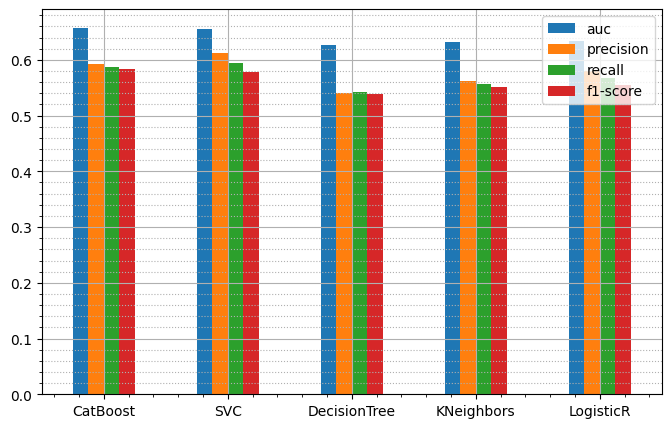

In [272]:
df_metrics = pd.DataFrame.from_dict(summary_metrics, orient='index')
ax = df_metrics.plot(kind='bar', rot=0, figsize=(8,5), grid=True)
ax.grid(True, which='minor', axis='y', linestyle=':')
ax.minorticks_on()

1.6 Инициализация базовых алгоритмов с лучшими параметрами

In [276]:
# Базовые алгоритмы
svc = SVC(C= 1, gamma= 0.1, kernel= 'rbf')
dtc = DecisionTreeClassifier(max_depth=8, max_features= None, min_samples_leaf= 2, min_samples_split= 2, random_state=RANDOM_STATE)
knc = KNeighborsClassifier(leaf_size= 5, metric= 'minkowski', n_neighbors= 13, p= 1, weights= 'distance')
lrc = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear', max_iter=1000, random_state=RANDOM_STATE)

### 2. Реализация ансамбля методом стэкинга (Stacking)

In [277]:
# Пример реализации стэкинга моделей

base_models = [svc, dtc, knc, lrc]
meta_model = RidgeClassifier(alpha= 0.001)

class myStackingClassifier():  

    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.base_models_prediction = None
        
    def fit(self, X, y, p=0.25, random_state=None):
        # разбиение данных для обучения базовых моделей метамодели
        X_base, X_meta, y_base, y_meta = train_test_split(X, y, test_size=p, random_state=random_state)
        # инициализация матрицы данных для обучения метамодели
        self.base_models_prediction = np.zeros((X_meta.shape[0], len(self.base_models)))

        # обучение базовых моделей и заполнение матрицы для обучения метамодели
        for i, model in enumerate(self.base_models):
            model.fit(X_base, y_base)
            self.base_models_prediction[:, i] = model.predict(X_meta)
                
        # обучение метамодели
        self.meta_model.fit(self.base_models_prediction, y_meta)
        return self
    
    def predict(self, X):
        # инициализация матрицы данных для метамодели
        X_meta = np.zeros((X.shape[0], len(self.base_models)))
        # заполнение матрицы для метамодели
        for i, m in enumerate(self.base_models):
            X_meta[:, i] = m.predict(X)
        
        return self.meta_model.predict(X_meta)

In [281]:
stc = myStackingClassifier(base_models, meta_model)
stc.fit(X_train, y_train, p=0.2, random_state=RANDOM_STATE)

y_pred = stc.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
summary_metrics['Stacking'] = get_avg_metrics(y_test, y_pred, lbnr)

AUC weighted: 0.623
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       325
           1       0.52      0.77      0.62       448
           2       0.60      0.06      0.10       216

    accuracy                           0.57       989
   macro avg       0.59      0.48      0.45       989
weighted avg       0.58      0.57      0.51       989



### 2. Реализация ансамбля методом бэггинга (Bagging)

In [282]:
# Пример реализации алгоритма бэгинга
from sklearn.base import clone

class myBaggingClassifier():  

    def __init__(self, estimator, n_estimators=10):
        self.estimator = estimator
        self.n_estimators = n_estimators
        
    def fit(self, X, y):
        N = len(X)
        self.estimators = []
        # обучение заданного количества моделей на случайным образом выбранных данных
        for e in range(self.n_estimators):
            # сформировать случайную выборку с повторением
            idx = np.random.randint(0,N,N) 
            Xe, Ye = X[idx], y[idx]
            # обучить новую модель на случайной выборке
            est = clone(self.estimator)
            self.estimators.append(est.fit(Xe, Ye))

        return self
            
    def predict(self, X):
        predicts = np.zeros(len(X))
        for est in self.estimators:
            predicts += est.predict(X)
        
        return np.round(predicts / self.n_estimators)

In [283]:
bagg = myBaggingClassifier(svc, n_estimators=200)
bagg.fit(X_train, y_train)

y_pred = bagg.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
summary_metrics['SVCBagging'] = get_avg_metrics(y_test, y_pred, lbnr)

AUC weighted: 0.648
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       325
           1       0.54      0.71      0.61       448
           2       0.64      0.28      0.39       216

    accuracy                           0.58       989
   macro avg       0.61      0.54      0.55       989
weighted avg       0.60      0.58      0.57       989



In [284]:
bagg = myBaggingClassifier(knc, n_estimators=200)
bagg.fit(X_train, y_train)

y_pred = bagg.predict(X_test)
print_full_metrics(y_test, y_pred, lbnr)
summary_metrics['KNeighBagging'] = get_avg_metrics(y_test, y_pred, lbnr)

AUC weighted: 0.635
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       325
           1       0.53      0.71      0.61       448
           2       0.63      0.32      0.42       216

    accuracy                           0.57       989
   macro avg       0.59      0.52      0.54       989
weighted avg       0.58      0.57      0.56       989



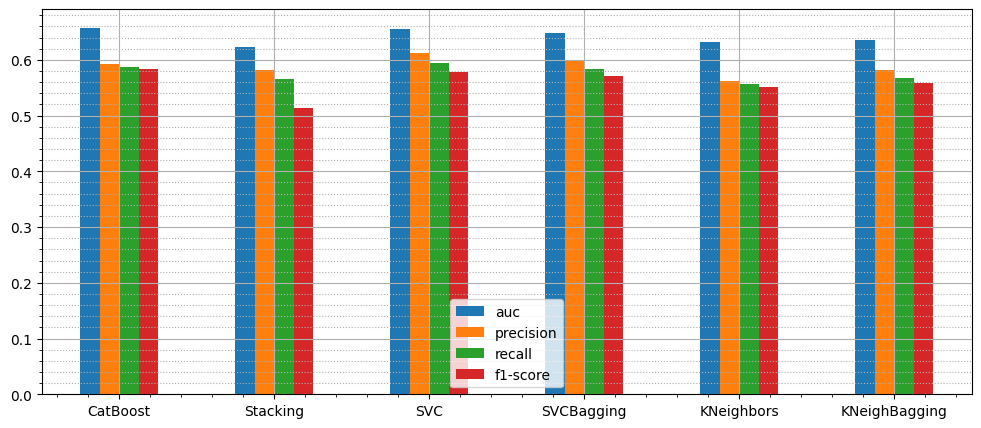

In [285]:
models_to_compare = ['CatBoost','Stacking','SVC','SVCBagging','KNeighbors','KNeighBagging']

df_metrics = pd.DataFrame.from_dict(summary_metrics, orient='index')
df_filtered = df_metrics.loc[models_to_compare]

ax = df_filtered.plot(kind='bar', rot=0, figsize=(12,5), grid=True)
ax.grid(True, which='minor', axis='y', linestyle=':')
ax.minorticks_on()

### 3. Реализация ансамбля методом бустинга (Boosting)

##### 3.1 Вариант N1. 
Итеративное (N шагов) обучение модели для заданного алгоритма на одном и том же наборе данных,  
из которого, на каждом шаге, удаляется заданный процент успешно предсказанных значений.  
Визуализация изменений метрик качества модели с шагом итерации.

2967: {'auc': 0.6554754208719966, 'precision': 0.612295653235712, 'recall': 0.5945399393326593, 'f1-score': 0.5786845216546944}
2870: {'auc': 0.6586586714343198, 'precision': 0.6170977629299297, 'recall': 0.5985844287158746, 'f1-score': 0.5833639178854735}
2778: {'auc': 0.6554386375443932, 'precision': 0.6046128107698721, 'recall': 0.5925176946410515, 'f1-score': 0.5797868441969752}
2690: {'auc': 0.6474489937617146, 'precision': 0.5996997082579905, 'recall': 0.5844287158746209, 'f1-score': 0.5701072230044524}
2607: {'auc': 0.645204076379215, 'precision': 0.5904022402269172, 'recall': 0.5803842264914054, 'f1-score': 0.5652376814755893}
2528: {'auc': 0.6501069096937112, 'precision': 0.5922420425053042, 'recall': 0.583417593528817, 'f1-score': 0.5751039123317361}
2452: {'auc': 0.642237566190903, 'precision': 0.5825622268013931, 'recall': 0.5743174924165824, 'f1-score': 0.5649589881995997}
2380: {'auc': 0.6481296347749046, 'precision': 0.5857824704392267, 'recall': 0.5783619817997978, 'f1-

<AxesSubplot: >

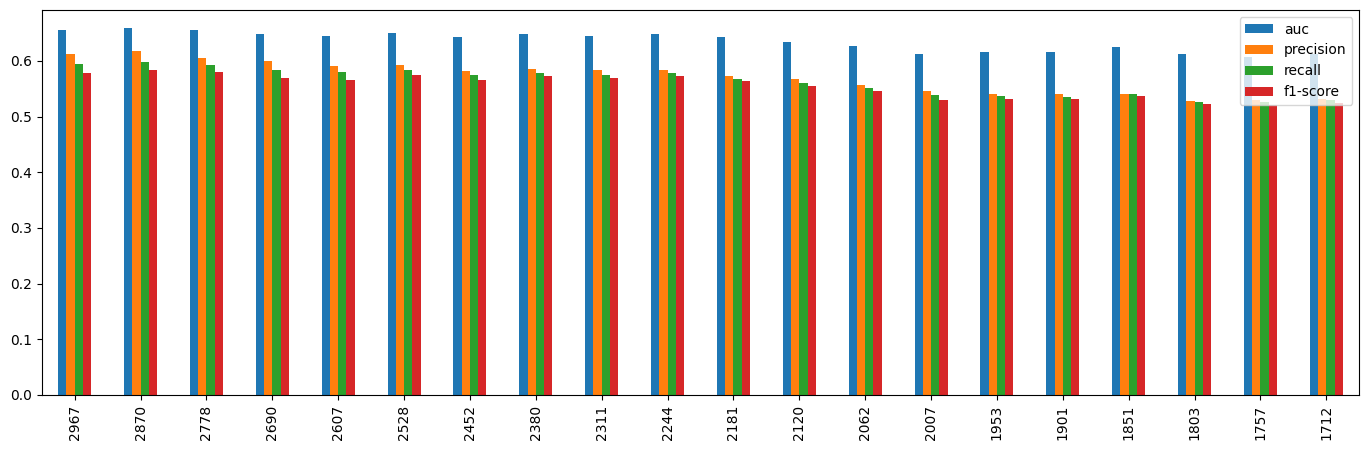

In [286]:
# [svc, dtc, knc, lrc]
model = svc

iter = 20
frac = 0.05
result = {}
Xi, Yi = X_train, y_train

for i in range(iter):
    model.fit(Xi,Yi)   
    Yp = model.predict(Xi)

    # Собрать метрики модели для тестового набора данных, на текущей итерации
    Yp2 = model.predict(X_test)
    a = metrics.roc_auc_score(lbnr.transform(y_test), lbnr.transform(Yp2), multi_class='ovr' ,average='weighted')
    m = metrics.classification_report(y_test,Yp2, zero_division=0, output_dict=True)['weighted avg']
    result[len(Xi)] = {'auc':a, 'precision':m['precision'], 'recall':m['recall'], 'f1-score':m['f1-score'] }

    # Выделить индексы верно предсказанных значений
    idx_pr_true = np.where(Yp == Yi)[0]
    # Выделить индексы неверно предсказанных значений
    idx_pr_false = np.where(Yp != Yi)[0]
    # Сформировать случайный перечень индексов для исключения из массива предсказанных значений
    idx_to_exclude = np.random.choice(len(idx_pr_true), int(frac*len(idx_pr_true)), replace=False)
    # Исключить из массива предсказанных значений случайные frac% значений
    idx_pr_true = np.array([v for i, v in enumerate(idx_pr_true) if i not in idx_to_exclude])
    # Сформировать перечень индексов значений для нового обучающего набора
    idx_to_select = np.concatenate([idx_pr_true, idx_pr_false])

    Xi = Xi[idx_to_select]
    Yi = Yi[idx_to_select]

for r in result: print(f'{r}: {result[r]}')

df_metrics = pd.DataFrame.from_dict(result, orient='index')
df_metrics.plot.bar(figsize=(17, 5))

##### 3.2 Вариант N2. 
Реализовать дообучение (partial_fit) модели для алгоритма SGDClassifier

In [107]:
# Пример реализации бустинга
from sklearn.linear_model import SGDClassifier

class mySGDBoostingClassifier():  

    def __init__(self):
        self.estimator = None
        self.X = None
        self.y = None
        
    def fit(self, X, y, n_iter=10, frac=0.05):
        # Инициализация и запуск обучения модели
        self.X, self.y = X, y
        self.estimator = SGDClassifier()
        self.estimator.partial_fit(self.X,self.y, classes=np.unique(y))           

        # Итеративное дообучение данными из которых удаляются frac% от верно предсказанных
        for i in range(n_iter):
            # Получить предсказанные значения
            y_preds = self.estimator.predict(self.X)
            # Выделить индексы верно предсказанных значений
            idx_pred_true = np.where(y_preds == y_train)[0]
            # Выделить индексы неверно предсказанных значений
            idx_pred_false = np.where(y_preds != y_train)[0]
            # Сформировать случайный перечень индексов для исключения из массива предсказанных значений
            idx_to_exclude = np.random.choice(range(len(idx_pred_true)), int(frac*len(idx_pred_true)), replace=False)
            # Исключить из массива предсказанных значений случайные frac% значений
            idx_pred_true = np.array([v for i, v in enumerate(idx_pred_true) if i not in idx_to_exclude])
            # Сформировать перечень индексов значений для нового обучающего набора
            idx_to_select = np.concatenate([idx_pred_true, idx_pred_false])
            print(f'iteration {i} | idx_to_select: {idx_to_select}')
            self.X = self.X[idx_to_select]
            self.y = self.y[idx_to_select]

            # Дообучить модель скорректированным набором
            self.estimator.partial_fit(self.X,self.y)           
        return self
            
    def predict(self, X):
        return self.estimator.predict(X)

In [108]:
sgd_boosting = mySGDBoostingClassifier()
sgd_boosting.fit(X_train, y_train, n_iter=20, frac=0.05)

sgd_boosting_predicted = sgd_boosting.predict(X_test)
print('SGDClassifier boosting')
print_metrics(y_test, sgd_boosting_predicted)

iteration 0 | idx_to_select: [   1    2    3 ... 2965 2967 2968]
iteration 1 | idx_to_select: [0.]


C:\Temp\ipykernel_7504\2407439533.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  idx_pred_true = np.where(y_preds == y_train)[0]
C:\Temp\ipykernel_7504\2407439533.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  idx_pred_false = np.where(y_preds != y_train)[0]


IndexError: arrays used as indices must be of integer (or boolean) type